In [63]:
import sys
import os
import time
import numpy as np
import matplotlib.pyplot as plt
sys.path.insert(0, os.path.abspath(os.path.join(os.pardir, "src")))
from mamnatroot import MamNatRootSolver
import pandas as pd
from scipy.optimize import brentq
import warnings
warnings.filterwarnings('ignore')

In [28]:
functions = {
    "f1: Poly Simple": (lambda x: x**3 - 3*x + 1, "Simple"),
    "f2: Poly Tangent": (lambda x: (x - 1)**2 * (x + 2), "Multiple"),
    "f3: Poly Très Plat": (lambda x: x**4 * (x-2), "Multiple"),
    "f4: Wilkinson-like": (lambda x: np.prod([x-i for i in np.arange(1, 5.1, 0.5)]), "Simple"),
    "f5: Exp & Sin": (lambda x: np.exp(-x**2) - np.sin(x), "Simple"),
    "f6: Cosinus Tangent": (lambda x: (np.cos(2*x) - 0.5)**2, "Multiple"),
    "f7: Log & Tangent": (lambda x: np.where( np.asarray(x) != 0, np.asarray(x)**2 * np.log(np.asarray(x)**2 + 0.1), 0.0), "Multiple"),
    "f8: Bessel-like": (lambda x: np.where( np.asarray(x) != 0, np.sin(np.asarray(x))/np.asarray(x) - 0.1, 0.9), "Simple"),
    "f9: Double Tangence": (lambda x: (x**2-1)**2 * (x**2-4)**2, "Multiple"),
    "f10: Chaos Fréquentiel": (lambda x: np.sin(x) + np.sin(np.pi * x), "Multiple")
}
interval = (-np.pi, np.pi)

# --- Simulation ---
results_data = []
print("--- SIMULATION ---")

for name, (func, root_type) in functions.items():
    # print(f"\nTraitement de la fonction: {name} (Type: {root_type})")
    try:
        mnr_roots, mnr_time = MamNatRootSolver.find_all_roots(func, interval=interval, getRuntime=True)
        mnr_roots_arr = np.round(np.array(mnr_roots), 3)
        mnr_roots_str = mnr_roots_arr.tolist()
        mnr_status = f"{len(mnr_roots)} roots"
        mnr_time_str = f"{mnr_time:.6f}s"
        mnr_error = False
        # print(f"  MamNatRoot a trouvé {len(mnr_roots)} racines en {mnr_time:.4f}s.")
    except Exception as e:
        mnr_roots = []
        mnr_roots_arr = []
        mnr_roots_str = []
        mnr_status = "Erreur d'exécution"
        mnr_time_str = "N/A"
        mnr_error = True
        # print(f"  MamNatRoot a échoué: {e}")

    brentq_roots_found = 0
    brentq_roots = []
    start_time_brent = time.perf_counter()
    
    # brentq ne peut pas trouver les racines tangentes par design.
    if root_type == "Multiple":
        status = "Failed"
        brentq_time = "N/A"
        brentq_roots_arr = []
        brentq_roots_str = []
    else:
        brackets = []
        points = np.linspace(interval[0], interval[1], 2000)
        # Evaluate func on all points, but ensure the result is always a 1D numpy array
        try:
            y = func(points)
            # If y is a scalar (0-dim), convert to 1D array
            if np.isscalar(y) or (isinstance(y, np.ndarray) and y.ndim == 0):
                y = np.full_like(points, y, dtype=float)
            else:
                y = np.asarray(y)
                if y.shape != points.shape:
                    # Try to broadcast or fallback to scalar evaluation
                    y = np.array([func(pt) for pt in points])
        except Exception:
            # If func is not vectorized, fall back to scalar evaluation
            y = np.array([func(pt) for pt in points])
        for i in range(len(points) - 1):
            # Make sure y[i] and y[i+1] are valid scalars
            yi = y[i]
            yip1 = y[i+1]
            if np.sign(yi) != np.sign(yip1):
                brackets.append((points[i], points[i+1]))
        
        for br_a, br_b in brackets:
            try:
                sol = brentq(func, br_a, br_b)
                brentq_roots.append(sol)
                brentq_roots_found += 1
            except (ValueError, RuntimeError):
                pass 
        
        brentq_time_val = time.perf_counter() - start_time_brent
        status = f"{brentq_roots_found} roots"
        brentq_time = f"{brentq_time_val:.6f}s"
        brentq_roots_arr = np.round(np.array(brentq_roots), 3)
        brentq_roots_str = brentq_roots_arr.tolist()
    
    results_data.append([
        name, "MamNatRoot", mnr_status, mnr_time_str, mnr_roots_str, brentq_roots_str
    ])
    results_data.append([
        name, "Brentq", status, brentq_time, mnr_roots_str, brentq_roots_str
    ])
    # print(f"  Brentq a trouvé: {status}.\n ---------")
    # print(f"  MamNatRoot: {[f'{x:.7f}' for x in mnr_roots]} \t Brentq: {[f'{x:.7f}' for x in brentq_roots]}")

# --- Affichage des résultats ---
df = pd.DataFrame(
    results_data,
    columns=[
        "Function", "Method", "Roots", "Runtime",
        "MamNatRoot solutions", "Brentq solutions"
    ]
)
print("\n" + "="*130)
print("\t\t\t\t\t\t--- PERFORMANCE SUMMARY TABLE ---")
print("="*130)
print(df.to_string())
print("="*130)

--- SIMULATION ---

						--- PERFORMANCE SUMMARY TABLE ---
                  Function      Method    Roots    Runtime                           MamNatRoot solutions        Brentq solutions
0          f1: Poly Simple  MamNatRoot  3 roots  0.201768s                         [-1.879, 0.347, 1.532]  [-1.879, 0.347, 1.532]
1          f1: Poly Simple      Brentq  3 roots  0.009972s                         [-1.879, 0.347, 1.532]  [-1.879, 0.347, 1.532]
2         f2: Poly Tangent  MamNatRoot  2 roots  0.168624s                                    [-2.0, 1.0]                      []
3         f2: Poly Tangent      Brentq   Failed        N/A                                    [-2.0, 1.0]                      []
4       f3: Poly Très Plat  MamNatRoot  2 roots  0.166350s                                   [0.002, 2.0]                      []
5       f3: Poly Très Plat      Brentq   Failed        N/A                                   [0.002, 2.0]                      []
6       f4: Wilkinson-like  Ma

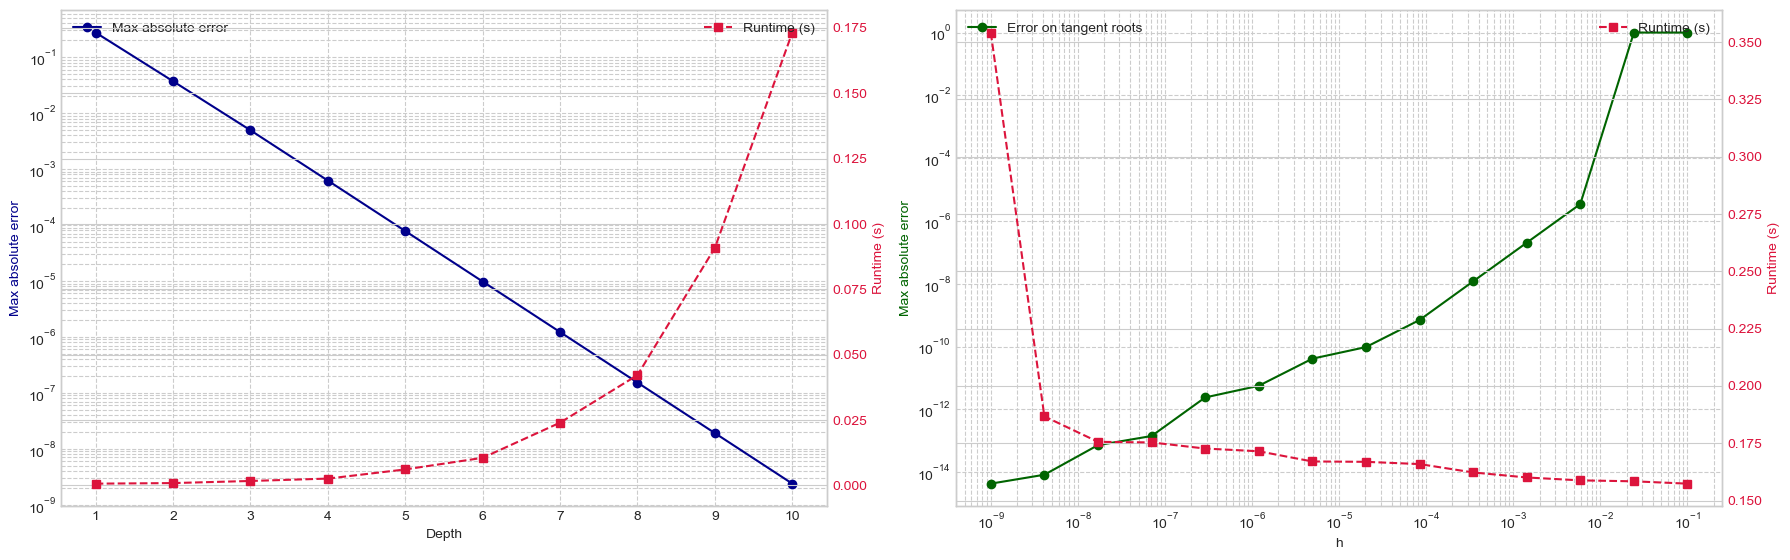

In [58]:
f_exact = lambda x: (x + 4) * (x - 1)**2
exact_roots = sorted([-4.0, 1.0])
interval_ = [-6, 6]

# --- 1. Analyse de l'impact de la profondeur 'depth' ---
depths = range(1, 11)
errors_d = []
runtimes_d = []

for d in depths:
    result = MamNatRootSolver.find_all_roots(f_exact, interval=interval_, depth=d, getRuntime=True)
    if isinstance(result, tuple) and len(result) == 2:
        found_roots, runtime_val = result
    else:
        found_roots = result
        runtime_val = np.nan
    if len(found_roots) != len(exact_roots):
        max_error = 1.0
    else:
        errors = [abs(fr - er) for fr, er in zip(sorted(found_roots), exact_roots)]
        max_error = max(errors) if errors else 0
    errors_d.append(max_error)
    runtimes_d.append(runtime_val)

# --- 2. Analyse de l'impact du pas de différence finie 'h' ---
hs = np.logspace(-9, -1, 14)
errors_h = []
runtimes_h = []

for h_param in hs:
    result = MamNatRootSolver.find_all_roots(f_exact, interval=interval_, h=h_param, getRuntime=True)
    if isinstance(result, tuple) and len(result) == 2:
        found_roots, runtime_val = result
    else:
        found_roots = result
        runtime_val = np.nan
    tangent_exact = [1.0]
    if len(found_roots) == 2:
        found_tangent = [found_roots[1]]
    else:
        found_tangent = []    
    if len(found_tangent) < len(tangent_exact):
        max_error = 1.0
    else:
        max_error = np.abs(found_tangent[0] - 1)
    errors_h.append(max_error)
    runtimes_h.append(runtime_val)

# --- Création des graphiques ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Graphique pour 'depth'
ax1.semilogy(depths, errors_d, 'o-', color='darkblue', label="Max absolute error")
ax1.set_xlabel("Depth")
ax1.set_ylabel("Max absolute error", color='darkblue')
# ax1.set_title("Impact de 'depth' sur la Précision et le Temps de Calcul")
ax1.grid(True, which="both", linestyle='--')
ax1.set_xticks(depths)
ax1.legend(loc='upper left')

# Ajout du runtime sur un second axe y
ax1b = ax1.twinx()
ax1b.plot(depths, runtimes_d, 's--', color='crimson', label="Runtime (s)")
ax1b.set_ylabel("Runtime (s)", color='crimson')
ax1b.tick_params(axis='y', labelcolor='crimson')
ax1b.legend(loc='upper right')

# Graphique pour 'h'
ax2.loglog(hs, sorted(errors_h), 'o-', color='darkgreen', label="Error on tangent roots")
ax2.set_xlabel("h")
ax2.set_ylabel("Max absolute error", color='darkgreen')
# ax2.set_title("Impact de 'h' sur la Précision des Racines Tangentes et le Temps de Calcul")
ax2.grid(True, which="both", linestyle='--')
ax2.legend(loc='upper left')

# Ajout du runtime sur un second axe y
ax2b = ax2.twinx()
ax2b.plot(hs, sorted(runtimes_h, reverse=True), 's--', color='crimson', label="Runtime (s)")
ax2b.set_ylabel("Runtime (s)", color='crimson')
ax2b.tick_params(axis='y', labelcolor='crimson')
ax2b.set_xscale('log')
ax2b.legend(loc='upper right')

# fig.suptitle("Analyse de Sensibilité des Paramètres de MamNatRootSolver", fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("metrics.png", dpi=330)
plt.show()

In [ ]:
functions = {
    "f1: Poly Simple": (lambda x: x**3 - 3*x + 1, "Simple"),
    "f2: Poly Tangent": (lambda x: (x - 1)**2 * (x + 2), "Multiple"),
    "f3: Poly Très Plat": (lambda x: x**4 * (x-2), "Multiple"),
    "f4: Wilkinson-like": (lambda x: np.prod([x-i for i in np.arange(1, 5.1, 0.5)], axis=0), "Simple"),
    "f5: Exp & Sin": (lambda x: np.exp(-x**2) - np.sin(x), "Simple"),
    "f6: Cosinus Tangent": (lambda x: (np.cos(2*x) - 0.5)**2, "Multiple"),
    "f7: Log & Tangent": (lambda x: np.where( np.asarray(x) != 0, np.asarray(x)**2 * np.log(np.asarray(x)**2 + 0.1), 0.0), "Multiple"),
    "f8: Bessel-like": (lambda x: np.where( np.asarray(x) != 0, np.sin(np.asarray(x))/np.asarray(x) - 0.1, 0.9), "Simple"),
    "f9: Double Tangence": (lambda x: (x**2-1)**2 * (x**2-4)**2, "Multiple"),
    "f10: Chaos Fréquentiel": (lambda x: np.sin(x) + np.sin(np.pi * x), "Multiple")
}
interval = (-np.pi, np.pi)


def generate_plot(func, interval, roots, filename):
    plt.figure(figsize=(4, 2))
    x_vals = np.linspace(interval[0], interval[1], 400)
    y_vals = func(x_vals)
    y_vals = np.asarray(y_vals).flatten()
    if y_vals.shape != x_vals.shape:
        if y_vals.size == 1:
            y_vals = np.full_like(x_vals, y_vals.item())
        else:
            raise ValueError(f"Function output shape {y_vals.shape} does not match x_vals shape {x_vals.shape}")
    plt.plot(x_vals, y_vals, color='b', lw=1.5)
    plt.axhline(0, color='black', linestyle='--', lw=1)
    if roots is not None and len(roots) > 0:
        roots_arr = np.array(roots, dtype=float).flatten()
        plt.plot(roots_arr, func(roots_arr), 'rX', markersize=5)
    plt.gca().set_ylim(bottom=min(-1, np.min(y_vals)-0.5), top=max(1, np.max(y_vals)+0.5))
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)
    plt.box(False)
    plt.tight_layout()
    plt.savefig(filename, dpi=300, transparent=True)
    plt.close()

# --- Simulation ---
results = {}
print("--- DÉBUT DE LA SIMULATION ET GÉNÉRATION DES GRAPHIQUES ---")

if not os.path.exists('plots'):
    os.makedirs('plots')

for i, (name, func_tuple) in enumerate(functions.items()):
    func_key = f"f{i+1}"
    print(f"\nTraitement de: {name} ({func_key})")
    func, _ = func_tuple
    results[name] = {"func": func}

    # --- MamNatRootSolver ---
    try:
        mnr_result = MamNatRootSolver.find_all_roots(func, interval=interval)
    except TypeError as e:
        print(f"  [ERREUR] lors de l'appel à find_all_roots pour {name}: {e}")
        mnr_result = ([], None)
    if isinstance(mnr_result, tuple) and len(mnr_result) == 2:
        mnr_roots, mnr_time = mnr_result
    else:
        mnr_roots = mnr_result
        mnr_time = None
    results[name]["mnr_roots"] = mnr_roots
    results[name]["mnr_time"] = mnr_time
    plot_filename = os.path.join('plots', f"{func_key}_plot.png")
    try:
        generate_plot(func, interval, mnr_roots, plot_filename)
    except Exception as e:
        print(f"  [ERREUR] lors de la génération du graphique pour {name}: {e}")
plt.close()

--- DÉBUT DE LA SIMULATION ET GÉNÉRATION DES GRAPHIQUES ---

Traitement de: f1: Poly Simple (f1)

Traitement de: f2: Poly Tangent (f2)

Traitement de: f3: Poly Très Plat (f3)

Traitement de: f4: Wilkinson-like (f4)

Traitement de: f5: Exp & Sin (f5)

Traitement de: f6: Cosinus Tangent (f6)

Traitement de: f7: Log & Tangent (f7)

Traitement de: f8: Bessel-like (f8)

Traitement de: f9: Double Tangence (f9)

Traitement de: f10: Chaos Fréquentiel (f10)
